<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/Predict_Stock_Price_with_LSTM_and_TCN_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [1]:
!pip install -q yfinance --upgrade --no-cache-dir

In [2]:
import yfinance as yf

stock_no = '^TWII'
start_time = '2000-01-01'
data = yf.download(stock_no, start=start_time)
# data = yf.download(stock_no, period="7d", interval="1m")

df = data

[*********************100%***********************]  1 of 1 completed


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

m = 20
n = 0.75

data['Return'] = (data['Close']-data['Close'].shift(1))/data['Close'].shift(1)
data['Volatility'] = data['Close'].rolling(m).std()
data = data.dropna()

In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Volatility
Date,,,,,,,,
2000-01-31,9653.240234,9749.509766,9613.799805,9744.889648,9744.852539,0,0.004948,290.885003
2000-02-01,9829.679688,9901.799805,9800.629883,9856.389648,9856.352539,0,0.011442,304.252308
2000-02-09,10137.240234,10137.240234,9932.070312,10008.879883,10008.841797,0,0.015471,330.239093
2000-02-10,10028.339844,10098.299805,9957.660156,10057.669922,10057.631836,0,0.004875,354.380327
2000-02-11,10171.799805,10227.330078,10096.540039,10128.669922,10128.631836,0,0.007059,368.772493


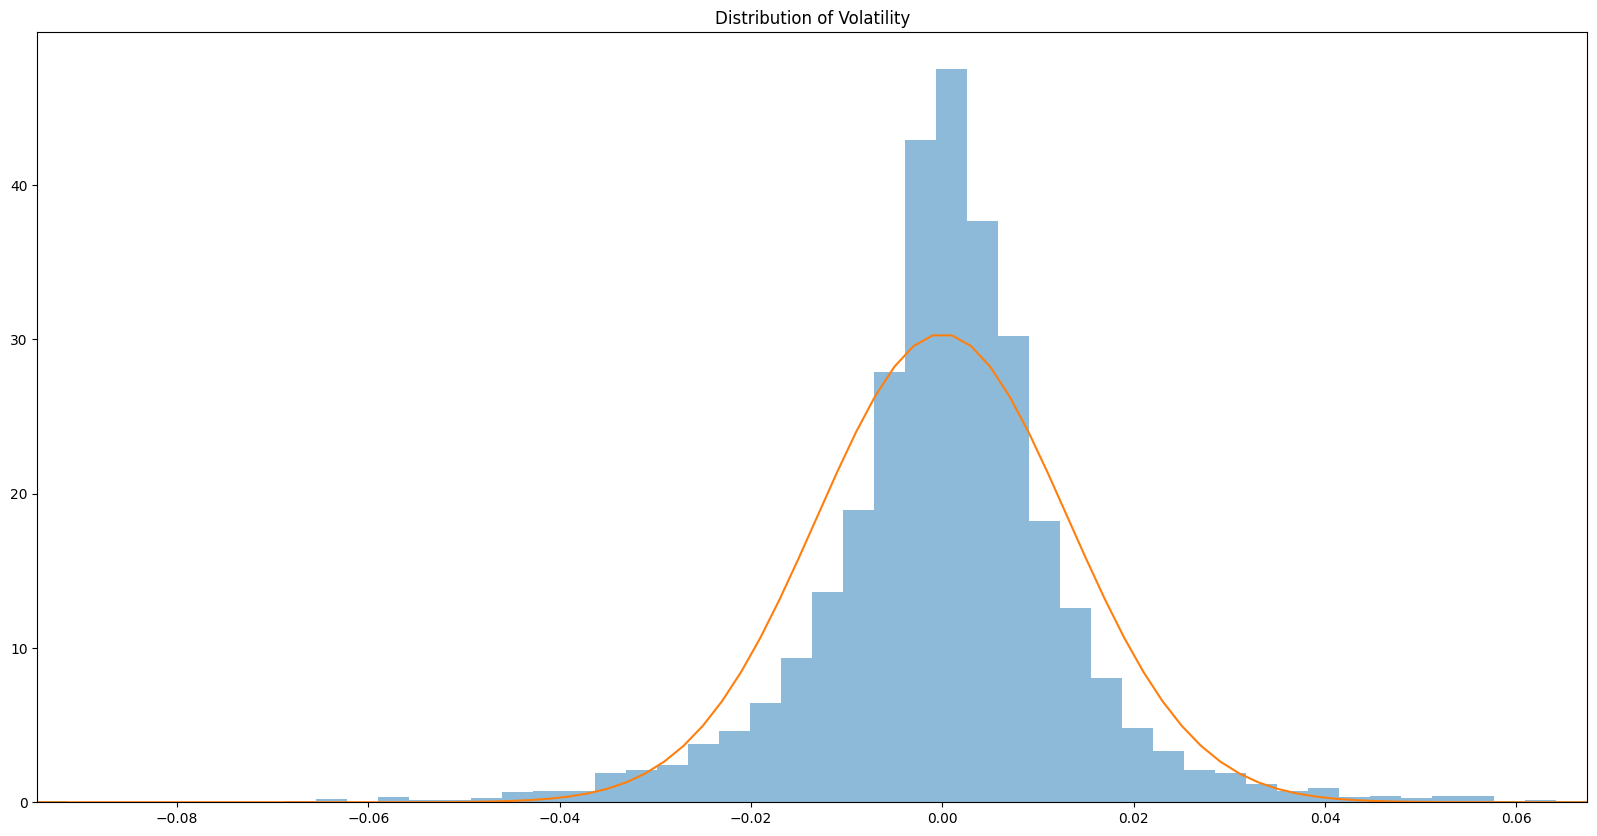

In [5]:
from scipy import stats
import seaborn as sns

plt.figure(figsize=(20,10))
plt.hist(data['Return'], bins=50, density=True, alpha=0.5)
x = np.linspace(-1, 1, 1000)
y = stats.norm.pdf(x, loc=0, scale=data['Return'].std())

sns.lineplot(x=x, y=y)
plt.title('Distribution of Volatility')
plt.xlim(min(data['Return']), max(data['Return']))
plt.show()

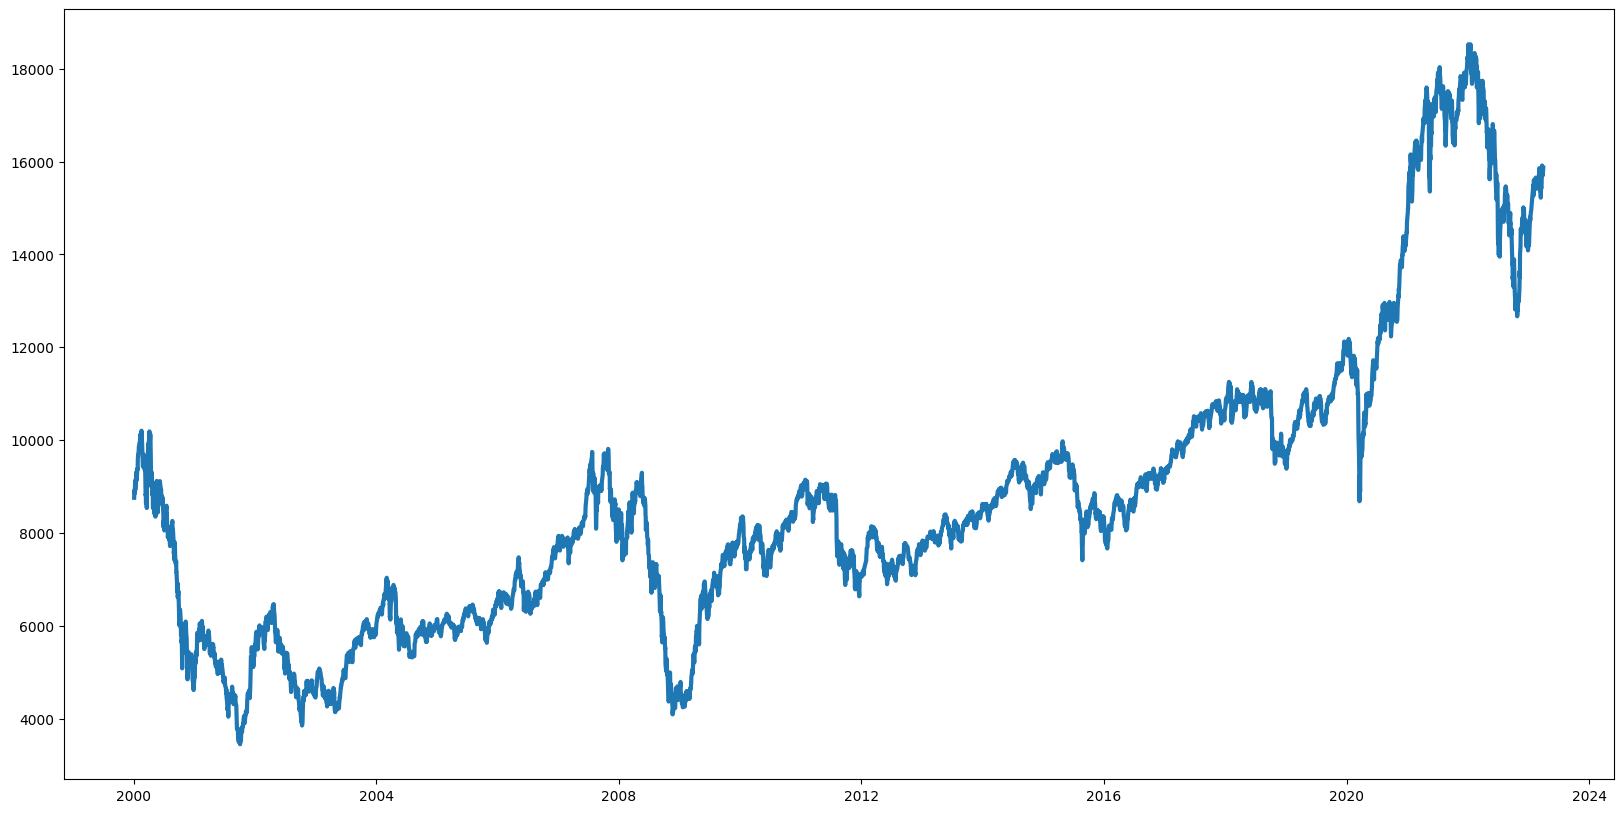

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(df['Close'], label='^TWII', linewidth=3)
plt.show()

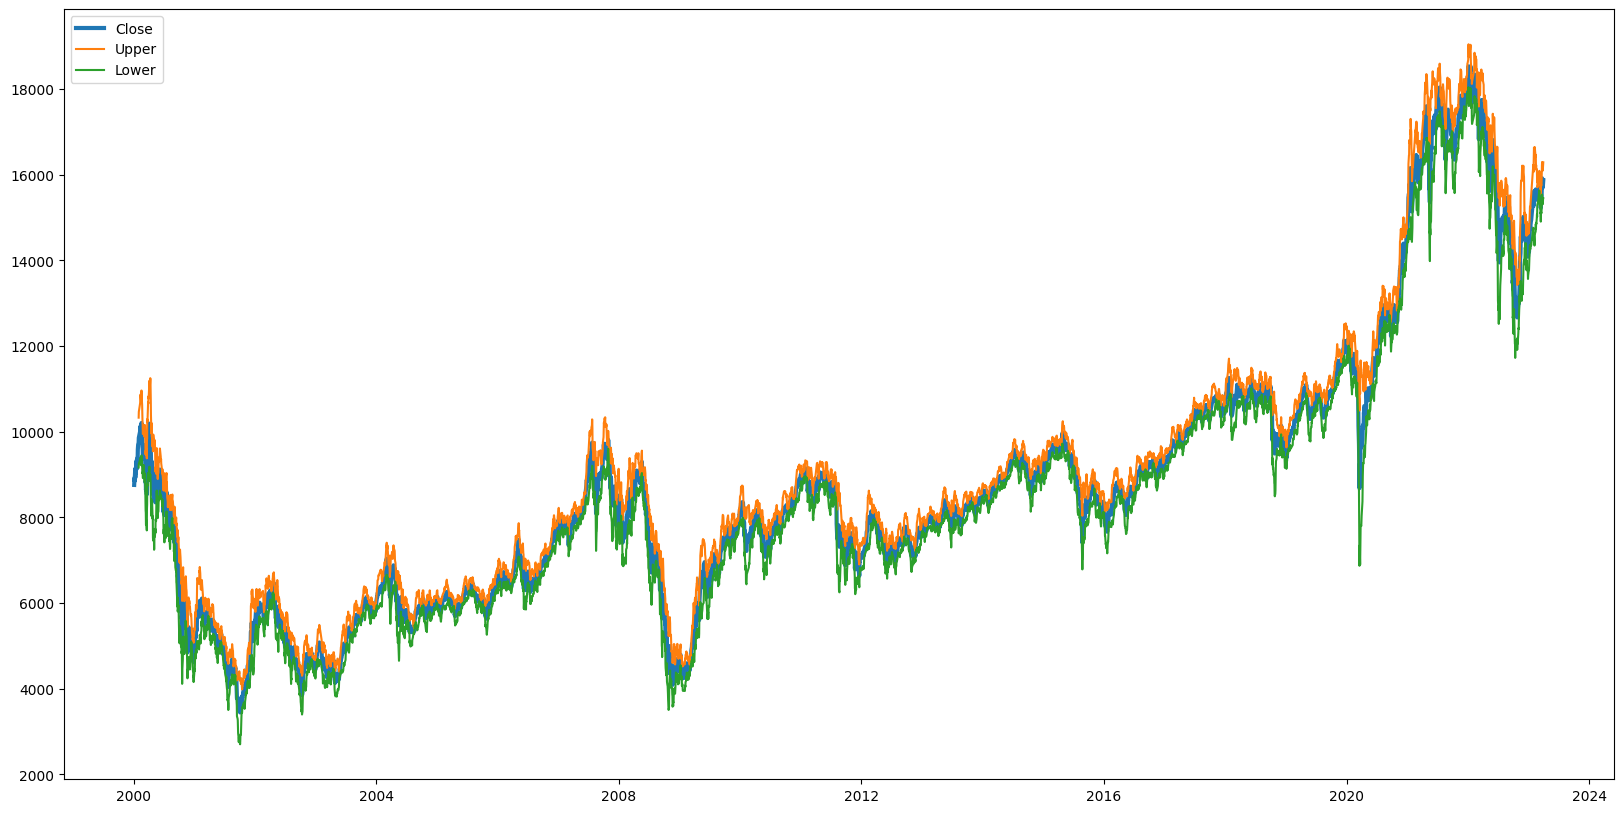

In [7]:
df['stddev'] = df['Close'].rolling(window=20).std()

df['Upper'] = df['Close'] + 2 * df['stddev']
df['Lower'] = df['Close'] - 2 * df['stddev']

plt.figure(figsize=(20, 10))
plt.plot(df['Close'], label='Close', linewidth=3)
plt.plot(df['Upper'], label='Upper')
plt.plot(df['Lower'], label='Lower')
plt.legend(loc='upper left')
plt.show()

#LSTM

In [20]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
df = df['Close']

In [25]:
df = df.dropna()

In [ ]:
train = df[0:int(n*df.shape[0]+1)].values
test = df[int(n*df.shape[0]):-1].values

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df, color = 'blue', label = 'df')  
plt.xlabel('Time')
plt.legend()
plt.show()

## Data Preprocessing

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train.reshape(-1, 1))

In [ ]:
x_train = []   #預測點的前 m 天的資料
y_train = []   #預測點
for i in range(m, len(train)):  
    x_train.append(train[i-m:i, 0])
    y_train.append(train[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)  

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=777, train_size=0.9)

In [ ]:
batch_size = 256

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.MeanSquaredError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

In [ ]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, LayerNormalization, Add, Flatten
from tensorflow.keras.layers import MultiHeadAttention
from keras.models import Model

In [ ]:
# Initialising the RNN
Input = Input(shape=(x_train.shape[1], 1))

# Adding the first LSTM layer and some Dropout regularisation
x = LSTM(units = 64, return_sequences = True)(Input)
x = Dropout(0.5)(x)

# Adding a second LSTM layer and some Dropout regularisation
x = LSTM(units = 64, return_sequences = True)(x)
x = Dropout(0.5)(x)

# Adding a third LSTM layer and some Dropout regularisation
x = LSTM(units = 64, return_sequences = False)(x)
x = Dropout(0.5)(x)

# Adding the output layer
output = Dense(units = 1)(x)

model = Model(Input, output)
model.summary()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [ ]:
# import time

# epochs = 100
# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch+1,))
#     start_time = time.time()

#     # Iterate over the batches of the dataset.
#     for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
#         loss_value = train_step(x_batch_train, y_batch_train)

#         # Log every 200 batches.
#         if step % 200 == 0:
#             print(
#                 "Training loss (for one batch) at step %d: %.4f"
#                 % (step, float(loss_value))
#             )
#             print("Seen so far: %d samples" % ((step + 1) * batch_size))

#     # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

#     # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

#     # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))
#     print("Time taken: %.2fs" % (time.time() - start_time))

## Model Training

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
red_lr = ReduceLROnPlateau(monitor='val_mae',patience=10,verbose=0,factor=0.1)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
model.fit(x_train, y_train, epochs = 100, batch_size = 64, callbacks=[callback, red_lr], validation_split = 0.2)

In [ ]:
inputs = df.values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(len(train), len(inputs)):  # timesteps
    X_test.append(inputs[i-m:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = sc.inverse_transform(Y_pred)  # to get the original scale

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error:",mean_absolute_error(test,Y_pred))
print("mean_squared_error:",mean_squared_error(test,Y_pred))
print("rmse:",sqrt(mean_squared_error(test,Y_pred)))
print("r2 score:",r2_score(test,Y_pred))

In [ ]:
# Visualising the results
plt.figure(figsize=(20,10))
plt.plot(test, color = 'red', label = 'Y_real')  
plt.plot(Y_pred, color = 'blue', label = 'Y_pred')  
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
open_arr1 = sc.transform(Y_pred.reshape(-1, 1)).reshape(-1)

In [ ]:
from tqdm import tqdm
last_value = open_arr1[-m:]
k = np.array([])
prediction_steps = 200
for i in tqdm(range(prediction_steps)):
  predicted_value = model.predict(last_value.reshape((-1, len(last_value), 1)), verbose=0)
  last_value = np.append(last_value, predicted_value)
  k = np.append(k, predicted_value)
  last_value = np.delete(last_value, 0)

In [ ]:
estimate = sc.inverse_transform(k.reshape(-1, 1)).reshape(-1)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(estimate, color = 'red', label = 'estimate')  
plt.xlabel('Time')
plt.legend()
plt.show()

## Volatilty Visualization

In [ ]:
interval = 500

y = pd.Series(Y_pred[-interval:].reshape(-1))
std = y.rolling(window=m).std()

up = y + 1.655 * std
down = y - 1.655 * std

plt.figure(figsize=(20, 10))
plt.plot(y, label='Predict', linewidth=3, color='red')
plt.plot(test[-interval:], label='Real', linewidth=3, color='blue')

plt.plot(up, label='Upper', linestyle='dashed', linewidth=3)
plt.plot(down, label='Lower', linestyle='dashed', linewidth=3)
plt.legend(loc='upper left')

# 標記買入和賣出時機
position = None
for i in range(len(y)):
  if y[i] < down[i] and position != 'buy':
    plt.plot(y.index[i], y[i], 'go', s=10)
    position = 'buy'
  elif y[i] > up[i] and position != 'sell':
    plt.plot(y.index[i], y[i], 'ro', s=10)
    position = 'sell'
plt.show()

#TCN

In [26]:
!pip install -q keras-tcn

In [27]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Flatten, Add, Activation
from keras.models import Model

## Hyperparameter

In [28]:
window_size = m
batch_size = 128   
epochs = 100       
filter_nums = 32
kernel_size = 3

In [29]:
scaler = MinMaxScaler()
open_arr = scaler.fit_transform(df.values.reshape(-1, 1)).reshape(-1)

In [30]:
X = np.zeros(shape=(len(open_arr) - window_size, window_size))
label = np.zeros(shape=(len(open_arr) - window_size))
for i in range(len(open_arr) - window_size):
    X[i, :] = open_arr[i:i+window_size]
    label[i] = open_arr[i+window_size]

In [31]:
k = int(X.shape[0]*n)
x_train = X[:k, :]
y_train = label[:k]
x_test = X[k:-1, :]
y_test = label[k:-1]

In [32]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=77777, train_size=0.9)

In [34]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((3839, 20, 1), (3839,), (427, 20, 1), (427,), (1421, 20, 1), (1421,))

In [35]:
from tcn.tcn import TCN

dilations = np.logspace(1, kernel_size, kernel_size, base=2, dtype=int).tolist()

model = keras.models.Sequential([
    keras.layers.Input(shape=(window_size, 1)),
    TCN(nb_filters=filter_nums,
        kernel_size=kernel_size,
        dilations=dilations),     
    keras.layers.Dense(units=1, activation='relu')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_1 (TCN)                 (None, 32)                15712     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,745
Trainable params: 15,745
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [36]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
red_lr = ReduceLROnPlateau(monitor='val_mae',patience=10,verbose=0,factor=0.1)

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[callback, red_lr])

Epoch 1/100
120/120 [==============================] - 5s 15ms/step - loss: 0.0020 - mae: 0.0257 - val_loss: 1.0814e-04 - val_mae: 0.0071 - lr: 0.0010
Epoch 2/100
120/120 [==============================] - 1s 11ms/step - loss: 6.9676e-05 - mae: 0.0063 - val_loss: 7.0648e-05 - val_mae: 0.0062 - lr: 0.0010
Epoch 3/100
120/120 [==============================] - 1s 12ms/step - loss: 6.9649e-05 - mae: 0.0064 - val_loss: 6.7701e-05 - val_mae: 0.0060 - lr: 0.0010
Epoch 4/100
120/120 [==============================] - 1s 11ms/step - loss: 6.2020e-05 - mae: 0.0061 - val_loss: 5.2377e-05 - val_mae: 0.0050 - lr: 0.0010
Epoch 5/100
120/120 [==============================] - 2s 14ms/step - loss: 7.3709e-05 - mae: 0.0066 - val_loss: 5.1933e-05 - val_mae: 0.0049 - lr: 0.0010
Epoch 6/100
120/120 [==============================] - 2s 16ms/step - loss: 7.3886e-05 - mae: 0.0066 - val_loss: 5.0311e-05 - val_mae: 0.0049 - lr: 0.0010
Epoch 7/100
120/120 [==============================] - 2s 14ms/step - loss

In [37]:
model.evaluate(x_test, y_test)
prediction = model.predict(x_test)
scaled_prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)
scaled_test_label = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

45/45 [==============================] - 0s 2ms/step


In [38]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error:",mean_absolute_error(scaled_prediction, scaled_test_label))
print("mean_squared_error:",mean_squared_error(scaled_prediction, scaled_test_label))
print("rmse:",sqrt(mean_squared_error(scaled_prediction, scaled_test_label)))
print("r2 score:",r2_score(scaled_prediction, scaled_test_label))

mean_absolute_error: 101.46911835855032
mean_squared_error: 21058.969830378104
rmse: 145.117090069978
r2 score: 0.9972028998479712


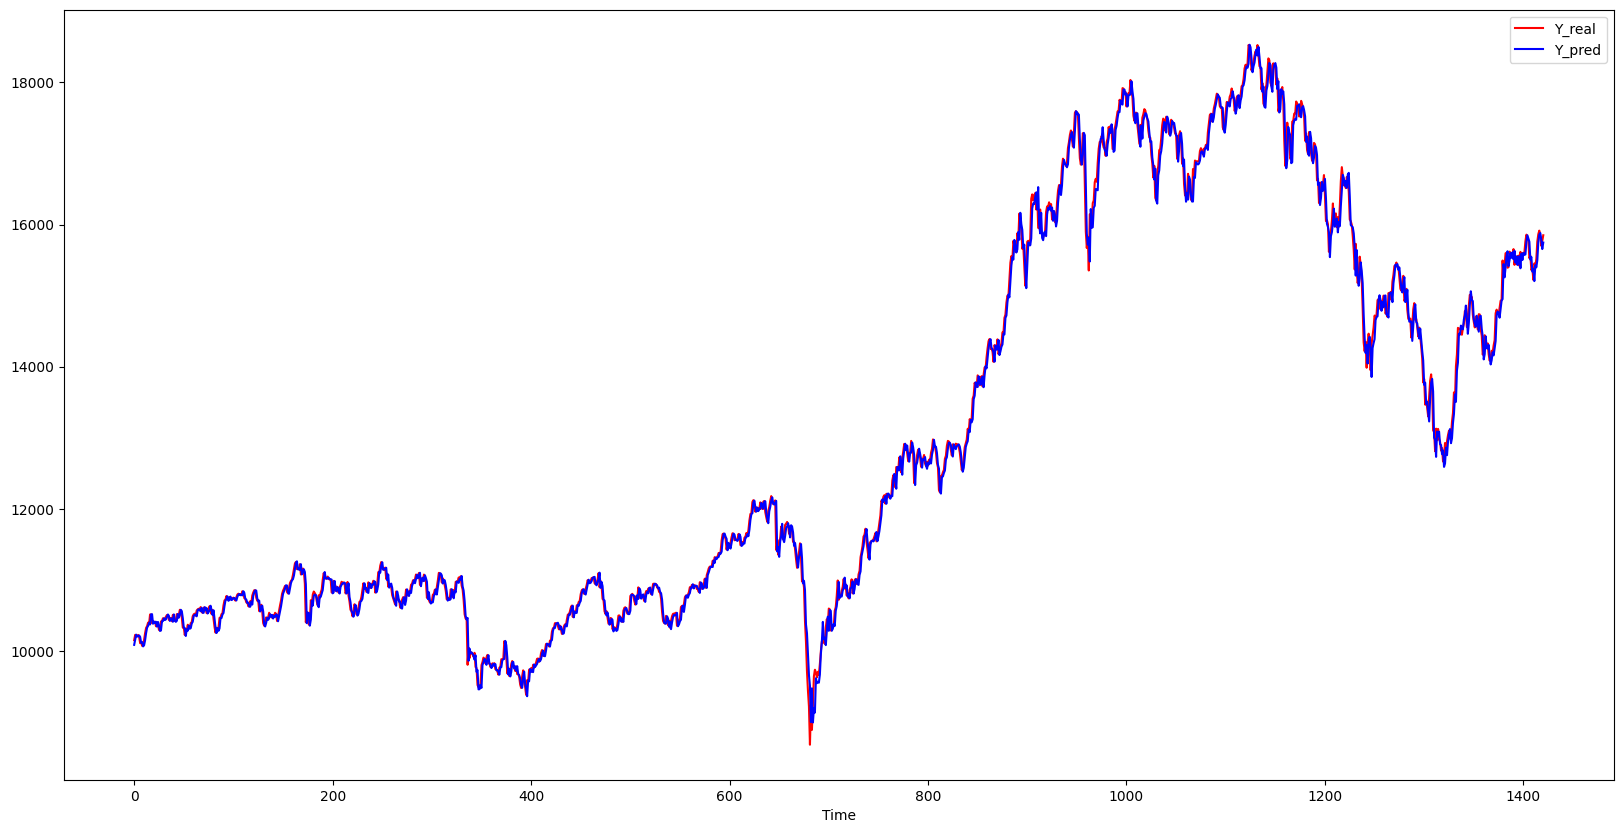

In [39]:
plt.figure(figsize=(20,10))
plt.plot(scaled_test_label, color = 'red', label = 'Y_real')  
plt.plot(scaled_prediction, color = 'blue', label = 'Y_pred')  
plt.xlabel('Time')
plt.legend()
plt.show()

In [40]:
open_arr1 = scaler.transform(scaled_prediction.reshape(-1, 1)).reshape(-1)

In [41]:
from tqdm import tqdm
last_value = open_arr1[-m:]
k = np.array([])
prediction_steps = 200
for i in tqdm(range(prediction_steps)):
  predicted_value = model.predict(last_value.reshape((-1, len(last_value), 1)), verbose=0)
  last_value = np.append(last_value, predicted_value)
  k = np.append(k, predicted_value)
  last_value = np.delete(last_value, 0)

100%|██████████| 200/200 [00:20<00:00,  9.89it/s]


In [42]:
estimate = scaler.inverse_transform(k.reshape(-1, 1)).reshape(-1)

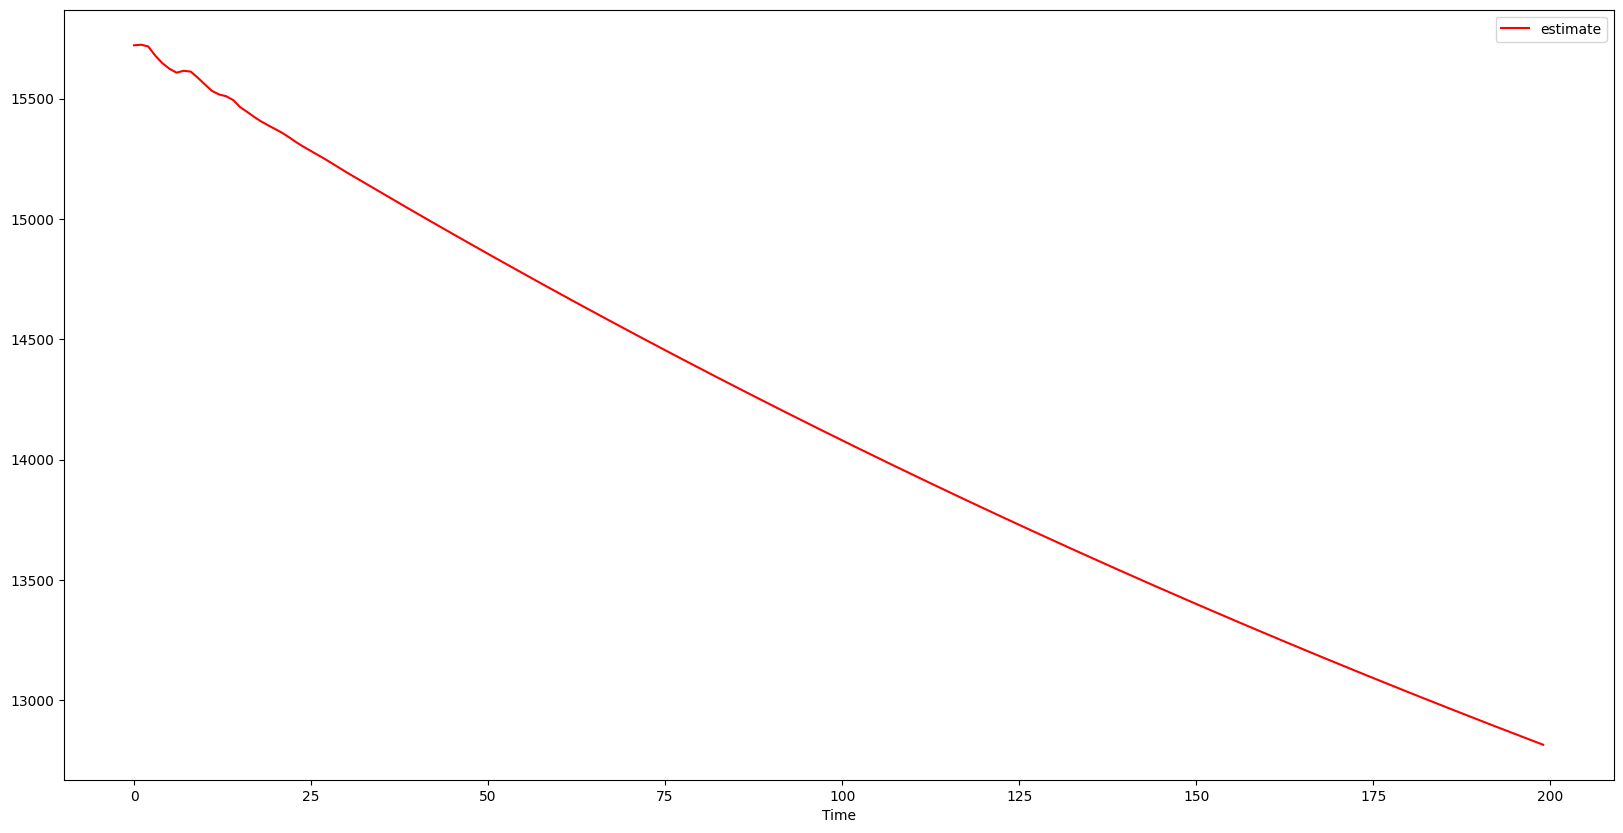

In [43]:
plt.figure(figsize=(20,10))
plt.plot(estimate, color = 'red', label = 'estimate')  
plt.xlabel('Time')
plt.legend()
plt.show()

## Volatilty Visualization

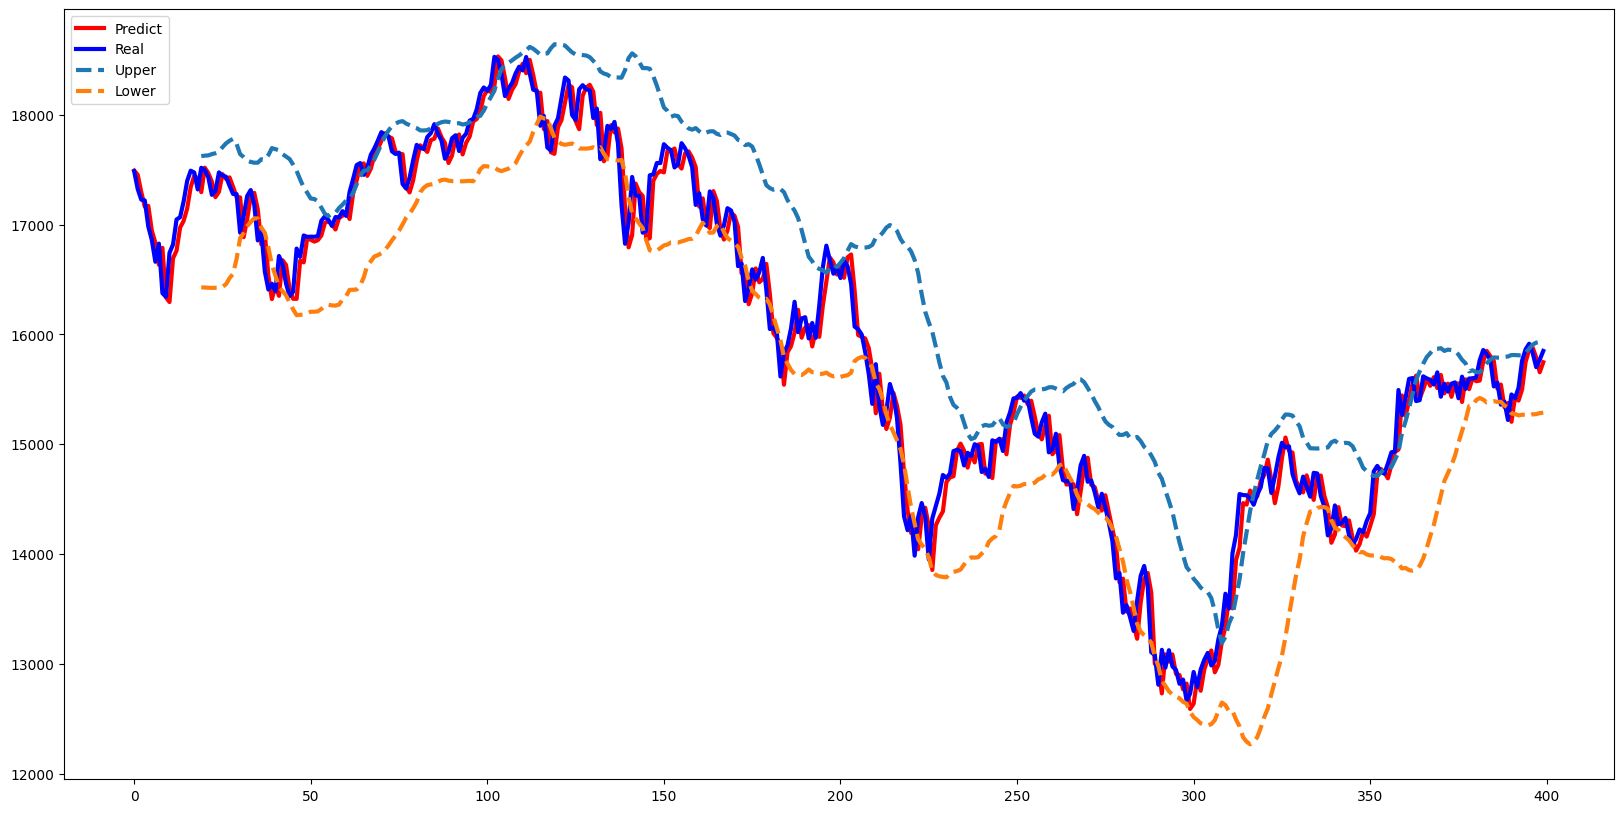

In [44]:
interval = 400

y = pd.Series(scaled_prediction[-interval:].reshape(-1))
mean = y.rolling(window=m).mean()
std = y.rolling(window=m).std()

up = mean + 1.655 * std
down = mean - 1.655 * std

plt.figure(figsize=(20, 10))
plt.plot(y, label='Predict', linewidth=3, color='red')
plt.plot(scaled_test_label[-interval:], label='Real', linewidth=3, color='blue')

plt.plot(up, label='Upper', linestyle='dashed', linewidth=3)
plt.plot(down, label='Lower', linestyle='dashed', linewidth=3)
plt.legend(loc='upper left')
plt.show()

# Transformer

In [8]:
df = df['Close']

In [9]:
train = df[0:int(n*df.shape[0]+1)].values
test = df[int(n*df.shape[0]):-1].values

In [10]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train.reshape(-1, 1))

In [11]:
import numpy as np

x_train = []   #預測點的前 m 天的資料
y_train = []   #預測點
for i in range(m, len(train)):  # 1258 是訓練集總數
    x_train.append(train[i-m:i, 0])
    y_train.append(train[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

In [12]:
inputs = df.values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

x_test = []
for i in range(len(train), len(inputs)):  # timesteps
    x_test.append(inputs[i-m:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Reshape 成 3-dimension

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, embed_dim=64, **kwargs):
    super(TokenAndPositionEmbedding, self).__init__(**kwargs)
    self.maxlen = maxlen
    self.embed_dim = embed_dim
    self.pos_emb = layers.Embedding(input_dim=self.maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    return x + positions
  def get_config(self): 
    config = super(TokenAndPositionEmbedding, self).get_config().copy()
    config.update({'maxlen': self.maxlen, 'embed_dim': self.embed_dim})
    return config

In [16]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    # embedding_layer = TokenAndPositionEmbedding(m)
    # x = embedding_layer(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="relu")(x)
    return keras.Model(inputs, outputs)

In [17]:
input_shape = (x_train.shape[1], 1)

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=10,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"]
    )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [18]:
# plt.figure(figsize=(8, 4))
# tf.keras.utils.plot_model(model, show_shapes=True)

## Model Training

In [ ]:
callbacks = [EarlyStopping(patience=100, restore_best_weights=True)]
red_lr = ReduceLROnPlateau(monitor='val_mae',patience=10,verbose=0,factor=0.1)

History = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[callbacks, red_lr]
)

In [22]:
Y_pred = model.predict(x_test)
Y_pred = sc.inverse_transform(Y_pred)  # to get the original scale

45/45 [==============================] - 1s 10ms/step


In [23]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error:",mean_absolute_error(test,Y_pred))
print("mean_squared_error:",mean_squared_error(test,Y_pred))
print("rmse:",sqrt(mean_squared_error(test,Y_pred)))
print("r2 score:",r2_score(test,Y_pred))

mean_absolute_error: 220.53518295823108
mean_squared_error: 81150.30386382969
rmse: 284.86892400511096
r2 score: 0.989293596799415


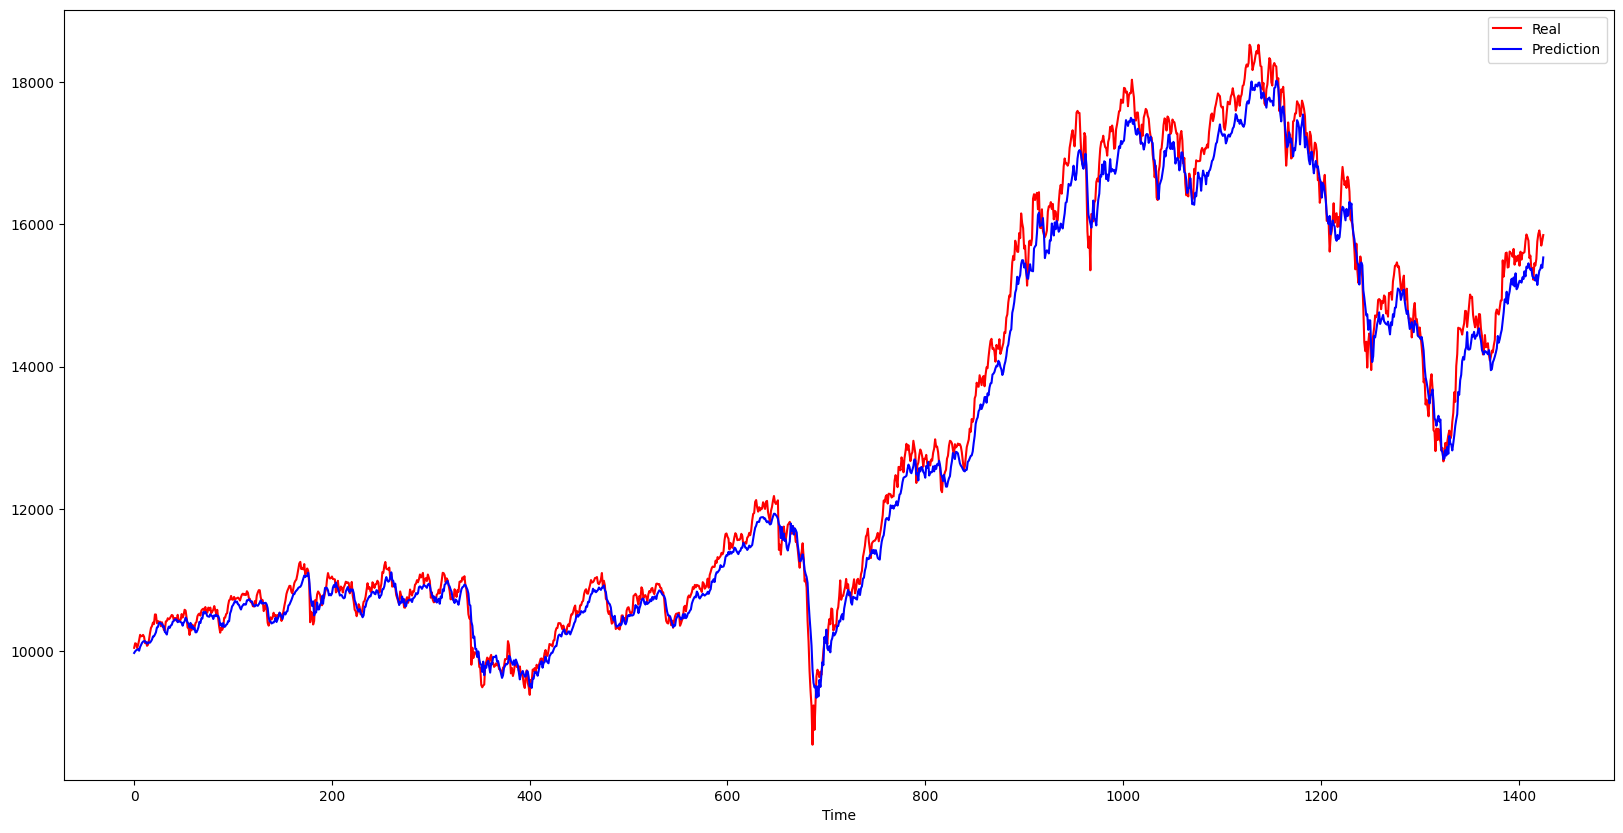

In [24]:
# Visualising the results
plt.figure(figsize=(20,10))
plt.plot(test, color = 'red', label = 'Real')  
plt.plot(Y_pred, color = 'blue', label = 'Prediction')  
plt.xlabel('Time')
plt.legend()
plt.show()

In [25]:
open_arr1 = sc.transform(Y_pred.reshape(-1, 1)).reshape(-1)

In [26]:
from tqdm import tqdm
last_value = open_arr1[-m:]
k = np.array([])
prediction_steps = 200
for i in tqdm(range(prediction_steps)):
  predicted_value = model.predict(last_value.reshape((-1, len(last_value), 1)), verbose=0)
  k = np.append(k, predicted_value)
  last_value = np.append(last_value, predicted_value)
  last_value = np.delete(last_value, 0)

100%|██████████| 200/200 [00:11<00:00, 17.12it/s]


In [27]:
k = sc.inverse_transform(k.reshape(-1, 1)).reshape(-1)

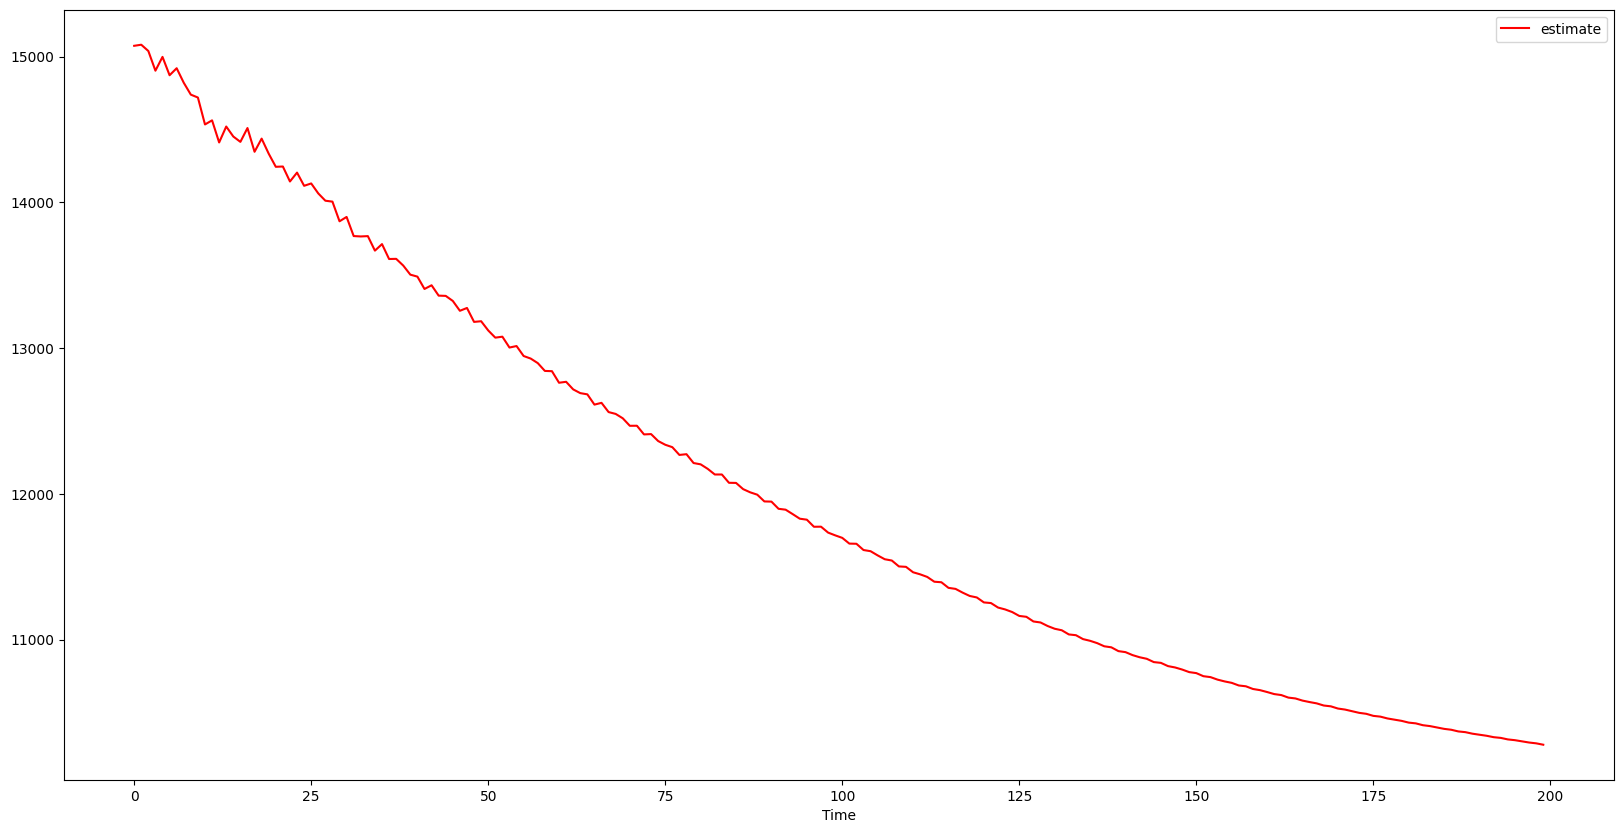

In [28]:
plt.figure(figsize=(20,10))
plt.plot(k, color = 'red', label = 'estimate')  
plt.xlabel('Time')
plt.legend()
plt.show()

## Volatilty Visualization

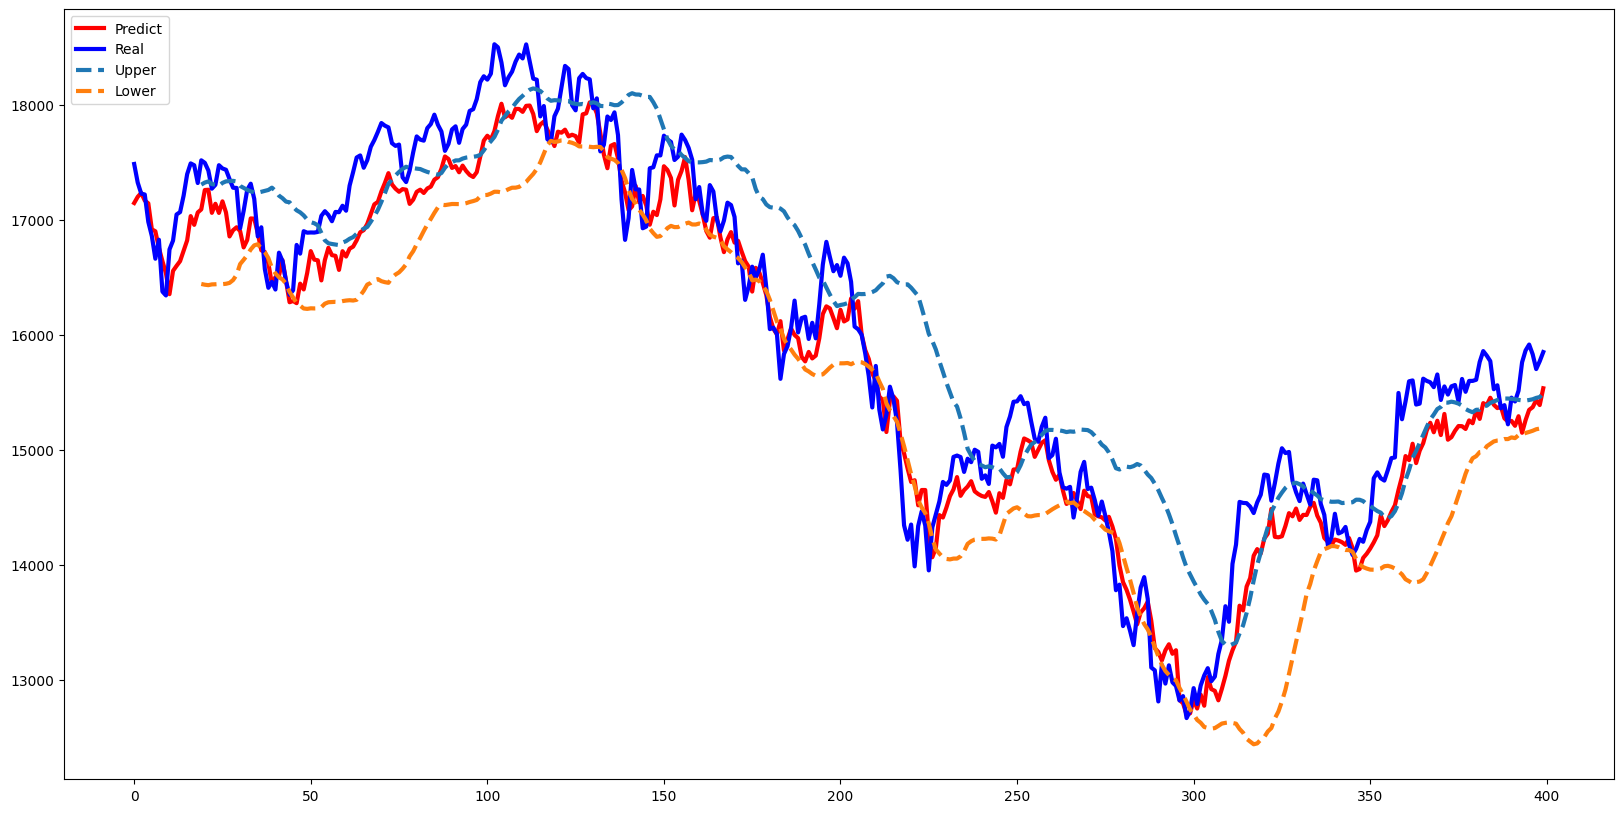

In [29]:
interval = 400

y = pd.Series(Y_pred[-interval:].reshape(-1))
std = y.rolling(window=m).std()
mean = y.rolling(window=m).mean()

up = mean + 1.655 * std
down = mean - 1.655 * std

plt.figure(figsize=(20, 10))
plt.plot(y, label='Predict', linewidth=3, color='red')
plt.plot(test[-interval:], label='Real', linewidth=3, color='blue')

plt.plot(up, label='Upper', linestyle='dashed', linewidth=3)
plt.plot(down, label='Lower', linestyle='dashed', linewidth=3)
plt.legend(loc='upper left')
plt.show()

# GARCH

In [ ]:
!pip install -q arch

In [ ]:
split_index = int(n*len(data['Return']))
train = data['Return'][: split_index]
test = data['Return'][split_index: ]

In [ ]:
from arch import arch_model

# Define range of p and q values to try
ps = range(0, 5)
qs = range(0, 5)

# Initialize empty DataFrame to store AIC and BIC values
results = pd.DataFrame(index=ps, columns=qs, dtype=float)

# Loop over p and q values and fit GARCH model
for p in ps:
  for q in qs:
    try:
      model = arch_model(train, vol='GARCH', p=p, o=0, q=q)
      results.loc[p, q] = model.fit(disp='off').aic
    except:
      continue

# Print the values of p and q that minimize AIC and BIC
print(f"Minimum AIC value: {results.stack().idxmin()} (AIC={results.stack().min():.2f})")
print(f"Minimum BIC value: {results.stack().idxmin()} (BIC={results.stack().min():.2f})")

# Plot AIC and BIC values
results.plot(figsize=(10, 6))
plt.title('AIC and BIC Values for GARCH Models')
plt.xlabel('q')
plt.ylabel('p')
plt.show()

In [ ]:
from arch import arch_model

garch_model = arch_model(train, mean='Zero', vol='GARCH', p=3, q=4)

# Fit the model
results = garch_model.fit(disp='off')

# Print the summary of the results
print(results.summary())

# Plot the estimated volatility
fig = plt.figure(figsize=(10,6))
plt.plot(train, label='Returns')
plt.plot(results.conditional_volatility, label='Volatility')
plt.legend()
plt.show()

In [ ]:
# Forecast the volatility of the test set
forecasts = results.forecast(horizon=len(test))

# Extract the forecasted conditional variance and standard deviation
forecasted_variance = forecasts.variance.iloc[-1].values
forecasted_stddev = np.sqrt(forecasted_variance)

# Compute the upper and lower bands for the test set
upper_band = test.mean() + 1.655 * forecasted_stddev
lower_band = test.mean() - 1.655 * forecasted_stddev

# Compute the proportion of observations that are within the bands
proportion_within_bands = ((test >= lower_band) & (test <= upper_band)).mean()

print(f"Proportion of observations within bands: {proportion_within_bands:.2%}")

# Plot the test set returns and the upper and lower bands
plt.figure(figsize=(10, 6))
plt.plot(test, label='Test Set Returns')
plt.fill_between(test.index, upper_band, lower_band, alpha=0.2)
plt.legend()
plt.title('GARCH Model with Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()